# **Predicting Bulldozer 🚜 Price Using Machine Learning -  Regression**

## **1. Problem Definition**
> How well can we predict the future sale price of a bulldozer, given its characteristics and previously given examples and is the sale price similar?
## **2. Data**
> The data is downloaded from Kaggle Blue Book for Bulldozers: https://www.kaggle.com/c/bluebook-for-bulldozers/

> The data for this competition is split into three parts:

* Train.csv is the training set, which contains data through the end of 2011.
* Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
* Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

## **3. Evaluation**
> The evaluation metrics for this is the RMSLE - Root Mean Squared Log Error - between predicted and auctioned prices.

**The goal for this machine learning project is to build a model that minimizes the RMSLE.**
## **4. Features**
> The key fields are in train.csv are:

* SalesID: the uniue identifier of the sale
* MachineID: the unique identifier of a machine.  A machine can be sold multiple times
* saleprice: what the machine sold for at auction (only provided in train.csv)
saledate: the date of the sale

In [118]:
# Importing standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Importing sklearn frameworks
import sklearn

In [119]:
# Mount drive to google colab
from google.colab import drive
drive.mount('/content/drive')

# load the dataset 
path = '/content/drive/My Drive/Colab_Notebooks/Personal/Udemy-Machine-Learning/bluebook-for-bulldozers/TrainAndValid.csv'

df = pd.read_csv(path)
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (13,39,40,41) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,11/16/2006 0:00,521D,521,D,NaN,NaN,NaN,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,3/26/2004 0:00,950FII,950,F,II,NaN,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,23.5,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2/26/2004 0:00,226,226,NaN,NaN,NaN,NaN,Skid Steer Loader - 1351.0 to 1601.0 Lb Operat...,New York,SSL,Skid Steer Loaders,NaN,OROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,5/19/2011 0:00,PC120-6E,PC120,NaN,-6E,NaN,Small,"Hydraulic Excavator, Track - 12.0 to 14.0 Metr...",Texas,TEX,Track Excavators,NaN,EROPS w AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,7/23/2009 0:00,S175,S175,NaN,NaN,NaN,NaN,Skid Steer Loader - 1601.0 to 1751.0 Lb Operat...,New York,SSL,Skid Steer Loaders,NaN,EROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [120]:
df.saledate[:5]

0    11/16/2006 0:00
1     3/26/2004 0:00
2     2/26/2004 0:00
3     5/19/2011 0:00
4     7/23/2009 0:00
Name: saledate, dtype: object

In [121]:
%%capture
df.describe(), df.info(), df.isna().sum()

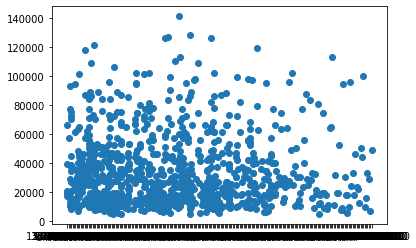

In [122]:
fig, ax = plt.subplots()
scatter = ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000]);


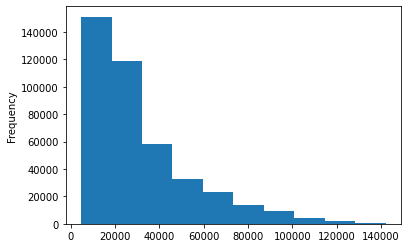

In [123]:
df.SalePrice.plot.hist();

### **Making Changes to the data**
#### **Parsing Dates**

When we want to work with Time Series data, we need to enrich the time and date component of the data as much as possible. To do this we will use `parse_dates` parameter

In [124]:
# Sale date's dtype is object, need to change that!
# Lets load the data again, but this time, lets parse the dates

df = pd.read_csv(path, low_memory=False, parse_dates= ["saledate"])
print(df.saledate[:5])
df.head(3)

0   2006-11-16
1   2004-03-26
2   2004-02-26
3   2011-05-19
4   2009-07-23
Name: saledate, dtype: datetime64[ns]


,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,521D,521,D,NaN,NaN,NaN,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,950FII,950,F,II,NaN,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,23.5,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,226,226,NaN,NaN,NaN,NaN,Skid Steer Loader - 1351.0 to 1601.0 Lb Operat...,New York,SSL,Skid Steer Loaders,NaN,OROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### **Exploratory Data Analysis**

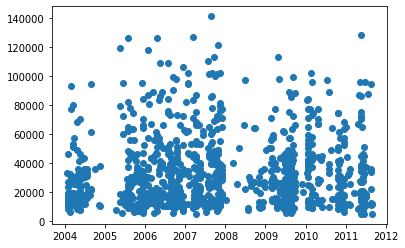

In [125]:
# Plotting saledate vs saleprice of the first 1000 bulldozers
fig, ax = plt.subplots()
scatter = ax.scatter(df['saledate'][:1000], df['SalePrice'][:1000]);

In [126]:
# Sort DataFrame by saledate

df.sort_values(by = ['saledate'], inplace = True, ascending= True)

# Making a copy of this dataframe for future reference
df_temp = df.copy()


In [127]:
# Where are most of the sales happening - top 5
df.state.value_counts()[:5]

Florida       67320
Texas         53110
California    29761
Washington    16222
Georgia       14633
Name: state, dtype: int64

### **Feature Engineering**

In [128]:
# Add datetime parameters for `saledate` column
df_temp["saleyear"] = df_temp.saledate.dt.year
df_temp["salemonth"] = df_temp.saledate.dt.month
df_temp["saleday"] = df_temp.saledate.dt.day
df_temp["saledayofweek"] = df_temp.saledate.dt.dayofweek
df_temp['saledayofyear'] = df_temp.saledate.dt.dayofyear

# Now that we have enriched the dataframe we can drop the saledate column
df_temp.drop('saledate', axis = 1, inplace = True)
df_temp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleyear,salemonth,saleday,saledayofweek,saledayofyear
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,TD20,TD20,NaN,NaN,NaN,Medium,"Track Type Tractor, Dozer - 105.0 to 130.0 Hor...",Texas,TTT,Track Type Tractors,NaN,OROPS,NaN,NaN,NaN,NaN,Direct Drive,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,17,1,17
274835,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,A66,A66,NaN,NaN,NaN,NaN,Wheel Loader - 120.0 to 135.0 Horsepower,Florida,WL,Wheel Loader,NaN,OROPS,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
141296,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,D7G,D7,G,NaN,NaN,Large,"Track Type Tractor, Dozer - 190.0 to 260.0 Hor...",Florida,TTT,Track Type Tractors,NaN,OROPS,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,31,1,31
212552,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,A62,A62,NaN,NaN,NaN,NaN,Wheel Loader - Unidentified,Florida,WL,Wheel Loader,NaN,EROPS,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
62755,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,D3B,D3,B,NaN,NaN,NaN,"Track Type Tractor, Dozer - 20.0 to 75.0 Horse...",Florida,TTT,Track Type Tractors,NaN,OROPS,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,Lever,NaN,NaN,1989,1,31,1,31


## **5. Modelling Part 1**
> * Before we get on with the modeling of the data, we need to make sure that all columns are numbers are their are no null values.
> * But before we make these changes to the data, we need to split the data into train and validation sets. If we do not do this, we are essentially using the validation data to make changes in the train data and vice versa

In [129]:
# Lets split the data into train and validation sets
df_val = df_temp[df_temp.saleyear == 2012]
df_train = df_temp[df_temp.saleyear != 2012]

df_val.head(3), df_train.head(3)

(        SalesID  SalePrice  MachineID  ...  saleday  saledayofweek  saledayofyear
 405675  4449186    46173.2    2318824  ...        1              6              1
 401133  1222855    66000.0     531393  ...        4              2              4
 406076  6258613    26800.0    1810917  ...        4              2              4
 
 [3 rows x 57 columns],
         SalesID  SalePrice  MachineID  ...  saleday  saledayofweek  saledayofyear
 205615  1646770     9500.0    1126363  ...       17              1             17
 274835  1821514    14000.0    1194089  ...       31              1             31
 141296  1505138    50000.0    1473654  ...       31              1             31
 
 [3 rows x 57 columns])

**Converting the strings to numbers - Training Set**

In [130]:
%%capture
# Convert strings to categories

## Find the columns that contain strings
for label, content in df_train.items():
  if pd.api.types.is_string_dtype(content):
    print(label)

In [131]:
for label, content in df_train.items():
  if pd.api.types.is_string_dtype(content):
    df_temp[label] = content.astype('category').cat.as_ordered()

Using pandas categories, we have access to all the columns as numbers.

**We still have missing data**

In [132]:
# Fill numeric values first
%%capture
for label, content in df_train.items():
  if pd.api.types.is_numeric_dtype(content):
    print(label)

In [133]:
## Finding the numeric columns with missing values
for label, content in df_train.items():
  if pd.api.types.is_numeric_dtype(content):
    if pd.isnull(content).sum():
      print(label)

auctioneerID
MachineHoursCurrentMeter


In [134]:
## Fill the numeric rows with the median of the columns because the median is not sensitive to outliers
%%capture
for label, content in df_train.items():
  if pd.api.types.is_numeric_dtype(content):
    if pd.isnull(content).sum():
      # add a binary column whuch tells us if the data was missing
      #df_train[label + "_is_missing"] = pd.isnull(content)
      #fill missing numeric values with median
      df_train[label] = content.fillna(content.median())

In [135]:
# Fill in categorical values
%%capture
for label, content in df_train.items():
  if not pd.api.types.is_numeric_dtype(content):
    print(label)

In [136]:
# Turn the categorical varaibles into number permatently and fill in the missing values
%%capture
for label, content in df_train.items():
  if not pd.api.types.is_numeric_dtype(content):
    # add binary column to indicate if column has missing values
    df_train[label + "_is_missing"] = pd.isnull(content)
    #turn catergories into numbers and add 1, since missing values will become -1 and we want them to be zero
    df_train[label] = pd.Categorical(content).codes + 1

In [137]:
df_train.info(), df_train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401125 entries, 205615 to 393123
Columns: 101 entries, SalesID to Steering_Controls_is_missing
dtypes: bool(44), float64(3), int16(4), int64(10), int8(40)
memory usage: 88.0 MB


(None, SalesID                         0
 SalePrice                       0
 MachineID                       0
 ModelID                         0
 datasource                      0
                                ..
 Backhoe_Mounting_is_missing     0
 Blade_Type_is_missing           0
 Travel_Controls_is_missing      0
 Differential_Type_is_missing    0
 Steering_Controls_is_missing    0
 Length: 101, dtype: int64)

In [138]:
df_train.head(), len(df_train)

(        SalesID  ...  Steering_Controls_is_missing
 205615  1646770  ...                          True
 274835  1821514  ...                         False
 141296  1505138  ...                          True
 212552  1671174  ...                         False
 62755   1329056  ...                          True
 
 [5 rows x 101 columns], 401125)

**Converting the strings to numbers - Validation Set**

In [139]:
%%capture
# Convert strings to categories

## Find the columns that contain strings
for label, content in df_val.items():
  if pd.api.types.is_string_dtype(content):
    print(label)

In [140]:
for label, content in df_val.items():
  if pd.api.types.is_string_dtype(content):
    df_temp[label] = content.astype('category').cat.as_ordered()

Using pandas categories, we have access to all the columns as numbers.

**We still have missing data**

In [141]:
# Fill numeric values first
%%capture
for label, content in df_val.items():
  if pd.api.types.is_numeric_dtype(content):
    print(label)

In [142]:
## Finding the numeric columns with missing values
for label, content in df_val.items():
  if pd.api.types.is_numeric_dtype(content):
    if pd.isnull(content).sum():
      print(label)

MachineHoursCurrentMeter


In [143]:
## Fill the numeric rows with the median of the columns because the median is not sensitive to outliers
%%capture
for label, content in df_val.items():
  if pd.api.types.is_numeric_dtype(content):
    if pd.isnull(content).sum():
      # add a binary column whuch tells us if the data was missing
      #df_val[label + "_is_missing"] = pd.isnull(content)
      #fill missing numeric values with median
      df_val[label] = content.fillna(content.median())

In [144]:
# Fill in categorical values
%%capture
for label, content in df_val.items():
  if not pd.api.types.is_numeric_dtype(content):
    print(label)

In [145]:
# Turn the categorical varaibles into number permatently and fill in the missing values
%%capture
for label, content in df_val.items():
  if not pd.api.types.is_numeric_dtype(content):
    # add binary column to indicate if column has missing values
    df_val[label + "_is_missing"] = pd.isnull(content)
    #turn catergories into numbers and add 1, since missing values will become -1 and we want them to be zero
    df_val[label] = pd.Categorical(content).codes + 1

In [146]:
df_val.info(), df_val.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11573 entries, 405675 to 409203
Columns: 101 entries, SalesID to Steering_Controls_is_missing
dtypes: bool(44), float64(3), int16(2), int64(10), int8(42)
memory usage: 2.5 MB


(None, SalesID                         0
 SalePrice                       0
 MachineID                       0
 ModelID                         0
 datasource                      0
                                ..
 Backhoe_Mounting_is_missing     0
 Blade_Type_is_missing           0
 Travel_Controls_is_missing      0
 Differential_Type_is_missing    0
 Steering_Controls_is_missing    0
 Length: 101, dtype: int64)

In [147]:
df_val.head(), len(df_val)

(        SalesID  ...  Steering_Controls_is_missing
 405675  4449186  ...                          True
 401133  1222855  ...                          True
 406076  6258613  ...                          True
 409018  6282680  ...                          True
 409026  6282759  ...                          True
 
 [5 rows x 101 columns], 11573)

Now we don't have any missing values 😁

## **5. Modelling Part 2**

In [148]:
# Instantiate the model
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()

In [149]:
# Split the data into X and y 
X_train, y_train = df_train.drop("SalePrice", axis =1), df_train["SalePrice"]
X_valid, y_valid = df_val.drop("SalePrice", axis =1), df_val["SalePrice"]

#### **Create evaluation function -> RMSLE**

In [150]:
from sklearn.metrics import mean_squared_log_error, mean_absolute_error,r2_score

def rmsle(y_test, y_preds):
  """
  Calcuates root mean squared log error btw predictions and true labels
  """
  return np.sqrt(mean_squared_log_error(y_test, y_preds))

# Create a function to evaluate model on different levels

def show_scores(model):
  train_preds = model.predict(X_train)
  val_preds = model.predict(X_valid)

  scores = {"Training R^2": r2_score(y_train, train_preds),
            "Valid R^2": r2_score(y_valid, val_preds),
            "Traning MAE": mean_absolute_error(y_train, train_preds),
            "Valid MAE": mean_absolute_error(y_valid, val_preds),
            "Training RMSLE": rmsle(y_train, train_preds),
            "Valid RMSLE": rmsle(y_valid, val_preds)}

  return scores

### **Testing our model on a subset(to tune the hyperparameters)**

In [151]:
# Initial testing: takes a long time
%%time
model = RandomForestRegressor(n_jobs = -1, random_state = 42)
model.fit(X_train, y_train)

CPU times: user 20min 9s, sys: 2.1 s, total: 20min 11s
Wall time: 10min 17s


In [152]:
show_scores(model)

{'Training RMSLE': 0.08418868478391799,
 'Training R^2': 0.9875307451537202,
 'Traning MAE': 1577.1670622873169,
 'Valid MAE': 10999.155915492958,
 'Valid RMSLE': 0.48893026414584023,
 'Valid R^2': 0.4945518171763198}

In [153]:
# Tune hyperparameters
%%time
%%capture

from sklearn.model_selection import RandomizedSearchCV

# Create inputs for RFR parameters
rf_grid = {"n_estimators": np.arange(10, 100, 10),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2),
           "max_features": [0.5, 1, "sqrt", "auto"],
           "max_samples": [10000]}

rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs = -1, random_state=42),
                              param_distributions = rf_grid,
                              n_iter = 100,
                              cv = 5,
                              verbose = True)
rs_model.fit(X_train, y_train)

CPU times: user 20min 54s, sys: 57.3 s, total: 21min 51s
Wall time: 41min 54s


In [154]:
rs_model.best_params_

{'max_depth': None,
 'max_features': 'auto',
 'max_samples': 10000,
 'min_samples_leaf': 1,
 'min_samples_split': 8,
 'n_estimators': 30}

In [155]:
show_scores(model)

{'Training RMSLE': 0.08418868478391799,
 'Training R^2': 0.9875307451537202,
 'Traning MAE': 1577.1670622873169,
 'Valid MAE': 10999.155915492958,
 'Valid RMSLE': 0.48893026414584023,
 'Valid R^2': 0.4945518171763198}

#### **Train the model with the best hyperparameters: found using 100 interations of `RandomizedSearchCV`**

In [156]:
# Most ideal hyperparameters, train on all the data
%%time
%%capture
ideal_model = RandomForestRegressor(n_estimators = 90,
                                    min_samples_leaf = 1,
                                    min_samples_split = 2,
                                    max_features = 'auto',
                                    n_jobs =-1,
                                    max_samples = None,
                                    random_state = 42)
ideal_model.fit(X_train, y_train)

CPU times: user 18min 18s, sys: 1.8 s, total: 18min 20s
Wall time: 9min 21s


In [157]:
show_scores(ideal_model)

{'Training RMSLE': 0.08439014468017554,
 'Training R^2': 0.987473265883128,
 'Traning MAE': 1579.8805565181265,
 'Valid MAE': 10989.093654771163,
 'Valid RMSLE': 0.48851205767382017,
 'Valid R^2': 0.4950580471033955}

## **6. Make Predictions on the Test Data**

In [158]:
# Importing the test data
path = '/content/drive/My Drive/Colab_Notebooks/Personal/Udemy-Machine-Learning/bluebook-for-bulldozers/Test.csv'
df_test = pd.read_csv(path, low_memory = False, parse_dates = ["saledate"])
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,580,G,NaN,NaN,NaN,Backhoe Loader - 14.0 to 15.0 Ft Standard Digg...,Wyoming,BL,Backhoe Loaders,Two Wheel Drive,OROPS,Yes,None or Unspecified,No,Standard,Standard,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,936,NaN,NaN,NaN,Medium,Wheel Loader - 135.0 to 150.0 Horsepower,Virginia,WL,Wheel Loader,NaN,EROPS,Yes,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,20.5,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,EC210,B,NaN,LC,Large / Medium,"Hydraulic Excavator, Track - 21.0 to 24.0 Metr...",New Jersey,TEX,Track Excavators,NaN,EROPS w AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,Steel,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,330,C,NaN,L,Large / Medium,"Hydraulic Excavator, Track - 33.0 to 40.0 Metr...",New Jersey,TEX,Track Excavators,NaN,EROPS w AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,Steel,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,650,K,NaN,NaN,NaN,"Track Type Tractor, Dozer - 20.0 to 75.0 Horse...",Florida,TTT,Track Type Tractors,NaN,OROPS,NaN,NaN,NaN,NaN,Hydrostatic,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


**Need to preprocess the data just like we did to the train/valid data**

In [159]:
# Add datetime parameters for `saledate` column
df_test["saleyear"] = df_test.saledate.dt.year
df_test["salemonth"] = df_test.saledate.dt.month
df_test["saleday"] = df_test.saledate.dt.day
df_test["saledayofweek"] = df_test.saledate.dt.dayofweek
df_test['saledayofyear'] = df_test.saledate.dt.dayofyear

# Now that we have enriched the dataframe we can drop the saledate column
df_test.drop('saledate', axis = 1, inplace = True)
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleyear,salemonth,saleday,saledayofweek,saledayofyear
0,1227829,1006309,3168,121,3,1999,3688.0,Low,580G,580,G,NaN,NaN,NaN,Backhoe Loader - 14.0 to 15.0 Ft Standard Digg...,Wyoming,BL,Backhoe Loaders,Two Wheel Drive,OROPS,Yes,None or Unspecified,No,Standard,Standard,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012,5,3,3,124
1,1227844,1022817,7271,121,3,1000,28555.0,High,936,936,NaN,NaN,NaN,Medium,Wheel Loader - 135.0 to 150.0 Horsepower,Virginia,WL,Wheel Loader,NaN,EROPS,Yes,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,20.5,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional,2012,5,10,3,131
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,EC210BLC,EC210,B,NaN,LC,Large / Medium,"Hydraulic Excavator, Track - 21.0 to 24.0 Metr...",New Jersey,TEX,Track Excavators,NaN,EROPS w AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,Steel,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN,2012,5,10,3,131
3,1227848,56204,1269,121,3,2006,8940.0,High,330CL,330,C,NaN,L,Large / Medium,"Hydraulic Excavator, Track - 33.0 to 40.0 Metr...",New Jersey,TEX,Track Excavators,NaN,EROPS w AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,Steel,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN,2012,5,10,3,131
4,1227863,1053887,22312,121,3,2005,2286.0,Low,650K,650,K,NaN,NaN,NaN,"Track Type Tractor, Dozer - 20.0 to 75.0 Horse...",Florida,TTT,Track Type Tractors,NaN,OROPS,NaN,NaN,NaN,NaN,Hydrostatic,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN,2012,5,10,3,131


In [160]:
%%capture
# Convert strings to categories

## Find the columns that contain strings
for label, content in df_test.items():
  if pd.api.types.is_string_dtype(content):
    print(label)

In [161]:
for label, content in df_test.items():
  if pd.api.types.is_string_dtype(content):
    df_temp[label] = content.astype('category').cat.as_ordered()

In [162]:
# Fill numeric values first
%%capture
for label, content in df_test.items():
  if pd.api.types.is_numeric_dtype(content):
    print(label)

In [163]:
## Finding the numeric columns with missing values
for label, content in df_test.items():
  if pd.api.types.is_numeric_dtype(content):
    if pd.isnull(content).sum():
      print(label)

MachineHoursCurrentMeter


In [164]:
## Fill the numeric rows with the median of the columns because the median is not sensitive to outliers
%%capture
for label, content in df_test.items():
  if pd.api.types.is_numeric_dtype(content):
    if pd.isnull(content).sum():
      # add a binary column whuch tells us if the data was missing
      #df_val[label + "_is_missing"] = pd.isnull(content)
      #fill missing numeric values with median
      df_test[label] = content.fillna(content.median())

In [165]:
# Fill in categorical values
%%capture
for label, content in df_test.items():
  if not pd.api.types.is_numeric_dtype(content):
    print(label)

In [166]:
# Turn the categorical varaibles into number permatently and fill in the missing values
%%capture
for label, content in df_test.items():
  if not pd.api.types.is_numeric_dtype(content):
    # add binary column to indicate if column has missing values
    df_test[label + "_is_missing"] = pd.isnull(content)
    #turn catergories into numbers and add 1, since missing values will become -1 and we want them to be zero
    df_test[label] = pd.Categorical(content).codes + 1

In [167]:
df_test.head(), len(df_test)

(   SalesID  ...  Steering_Controls_is_missing
 0  1227829  ...                          True
 1  1227844  ...                         False
 2  1227847  ...                          True
 3  1227848  ...                          True
 4  1227863  ...                          True
 
 [5 rows x 100 columns], 12457)

In [168]:
X_train.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,...,fiModelSeries_is_missing,fiModelDescriptor_is_missing,ProductSize_is_missing,fiProductClassDesc_is_missing,state_is_missing,ProductGroup_is_missing,ProductGroupDesc_is_missing,Drive_System_is_missing,Enclosure_is_missing,Forks_is_missing,Pad_Type_is_missing,Ride_Control_is_missing,Stick_is_missing,Transmission_is_missing,Turbocharged_is_missing,Blade_Extension_is_missing,Blade_Width_is_missing,Enclosure_Type_is_missing,Engine_Horsepower_is_missing,Hydraulics_is_missing,Pushblock_is_missing,Ripper_is_missing,Scarifier_is_missing,Tip_Control_is_missing,Tire_Size_is_missing,Coupler_is_missing,Coupler_System_is_missing,Grouser_Tracks_is_missing,Hydraulics_Flow_is_missing,Track_Type_is_missing,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
205615,1646770,1126363,8434,132,18.0,1974,0.0,0,4537,1735,0,0,0,4,47,44,5,5,0,6,0,0,0,0,3,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,...,True,True,False,False,False,False,False,True,False,True,True,True,True,False,True,True,True,True,True,False,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,True,True
274835,1821514,1194089,10150,132,99.0,1980,0.0,0,1800,557,0,0,0,0,60,9,6,6,0,6,1,0,2,0,0,0,0,0,0,0,1,0,0,0,0,17,3,0,0,0,...,True,True,True,False,False,False,False,True,False,False,True,False,True,True,True,True,True,True,True,False,True,True,True,True,False,False,True,True,True,True,True,True,True,True,True,True,True,True,False,False
141296,1505138,1473654,4139,132,99.0,1978,0.0,0,2324,711,57,0,0,2,50,9,5,5,0,6,0,0,0,0,8,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,...,True,True,False,False,False,False,False,True,False,True,True,True,True,False,True,True,True,True,True,False,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,True,True
212552,1671174,1327630,8591,132,99.0,1980,0.0,0,1799,556,0,0,0,0,74,9,6,6,0,1,1,0,2,0,0,0,0,0,0,0,1,0,0,0,0,17,3,0,0,0,...,True,True,True,False,False,False,False,True,False,False,True,False,True,True,True,True,True,True,True,False,True,True,True,True,False,False,True,True,True,True,True,True,True,True,True,True,True,True,False,False
62755,1329056,1336053,4089,132,99.0,1984,0.0,0,2095,681,21,0,0,0,51,9,5,5,0,6,0,0,0,0,8,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,...,True,True,True,False,False,False,False,True,False,True,True,True,True,False,True,True,True,True,True,False,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,True,True


In [169]:
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,...,fiModelSeries_is_missing,fiModelDescriptor_is_missing,ProductSize_is_missing,fiProductClassDesc_is_missing,state_is_missing,ProductGroup_is_missing,ProductGroupDesc_is_missing,Drive_System_is_missing,Enclosure_is_missing,Forks_is_missing,Pad_Type_is_missing,Ride_Control_is_missing,Stick_is_missing,Transmission_is_missing,Turbocharged_is_missing,Blade_Extension_is_missing,Blade_Width_is_missing,Enclosure_Type_is_missing,Engine_Horsepower_is_missing,Hydraulics_is_missing,Pushblock_is_missing,Ripper_is_missing,Scarifier_is_missing,Tip_Control_is_missing,Tire_Size_is_missing,Coupler_is_missing,Coupler_System_is_missing,Grouser_Tracks_is_missing,Hydraulics_Flow_is_missing,Track_Type_is_missing,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,25,0,0,0,2,51,1,1,4,3,2,2,1,2,7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,0,0,0,4,57,46,6,6,0,1,2,0,2,0,0,0,0,0,0,0,1,0,0,0,0,7,3,0,0,0,...,True,True,False,False,False,False,False,True,False,False,True,False,True,True,True,True,True,True,True,False,True,True,True,True,False,False,True,True,True,True,True,True,True,True,True,True,True,True,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,9,0,33,3,14,29,4,4,0,2,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,3,0,0,0,...,True,False,False,False,False,False,False,True,False,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,False,True,True,True,False,False,False,False,False,False,True,True,True,True,True
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,13,0,32,3,18,29,4,4,0,2,0,0,0,0,0,0,0,0,0,0,11,0,0,0,0,0,3,0,0,0,...,True,False,False,False,False,False,False,True,False,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,False,True,True,True,False,False,False,False,False,False,True,True,True,True,True
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,33,0,0,0,48,8,5,5,0,3,0,0,0,0,3,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,...,True,True,True,False,False,False,False,True,False,True,True,True,True,False,True,True,True,True,True,False,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,False,False,False,True,True


In [170]:
set(X_train.columns) - set(df_test.columns)

set()

**Now we can make predictions on the test data**

In [171]:
test_preds = ideal_model.predict(df_test)

In [172]:
test_preds

array([22337.77777778, 16960.        , 46866.66666667, ...,
       11971.66666667, 18263.88888889, 30880.77777778])

**Now we need to get the predictions into the same format that Kaggle is asking for:**
> https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation

In [173]:
# Create any empty dataframe
df_preds = pd.DataFrame()
df_preds["SalesID"] = df_test["SalesID"]
df_preds["SalePrice"] = test_preds
df_preds.head()

,SalesID,SalePrice
0,1227829,22337.777778
1,1227844,16960.000000
2,1227847,46866.666667
3,1227848,82388.888889
4,1227863,55804.444444


## **7. Feature Importance**

Finding the most important features from the dataset that are the most impactful when it comes to predicting the target variable

In [174]:
ideal_model.feature_importances_

array([4.98258121e-02, 1.65711144e-02, 3.24704360e-02, 4.50467402e-04,
       4.50767643e-03, 2.61336266e-01, 3.28428272e-03, 1.15859793e-03,
       1.99970387e-02, 7.89413696e-02, 5.14375127e-02, 4.32135359e-03,
       3.51063809e-03, 2.27098529e-01, 3.98077630e-02, 8.92644967e-03,
       2.07160786e-04, 2.26490592e-04, 1.69736676e-03, 8.85388679e-03,
       4.02503711e-04, 4.03301582e-05, 5.38121092e-04, 1.83544748e-04,
       1.63910979e-03, 2.78138874e-05, 2.11135880e-04, 6.38174883e-03,
       1.60879162e-04, 5.28887947e-05, 2.95700049e-03, 1.85557527e-03,
       2.27419999e-03, 4.06987033e-03, 2.58375197e-04, 1.69143381e-03,
       9.67396215e-04, 1.63401801e-02, 8.38044954e-06, 3.89595825e-06,
       1.85949715e-04, 1.12789024e-03, 1.33240439e-03, 7.62271590e-04,
       2.51330202e-04, 4.78363188e-04, 2.03331118e-04, 1.66020241e-03,
       9.63163256e-04, 1.68247556e-04, 2.41171153e-04, 7.64061050e-02,
       3.35482437e-03, 9.26997114e-03, 4.58792534e-03, 1.48447802e-02,
      

In [175]:
# Visualize the above feature importance

# Create a dataframe

df_plot = pd.DataFrame({"features": X_train.columns,
                        "feature_importance": ideal_model.feature_importances_}).sort_values("feature_importance", ascending =False).reset_index(drop = True)
df_plot.head()

,features,feature_importance
0,YearMade,0.261336
1,ProductSize,0.227099
2,fiBaseModel,0.078941
3,saleyear,0.076406
4,fiSecondaryDesc,0.051438


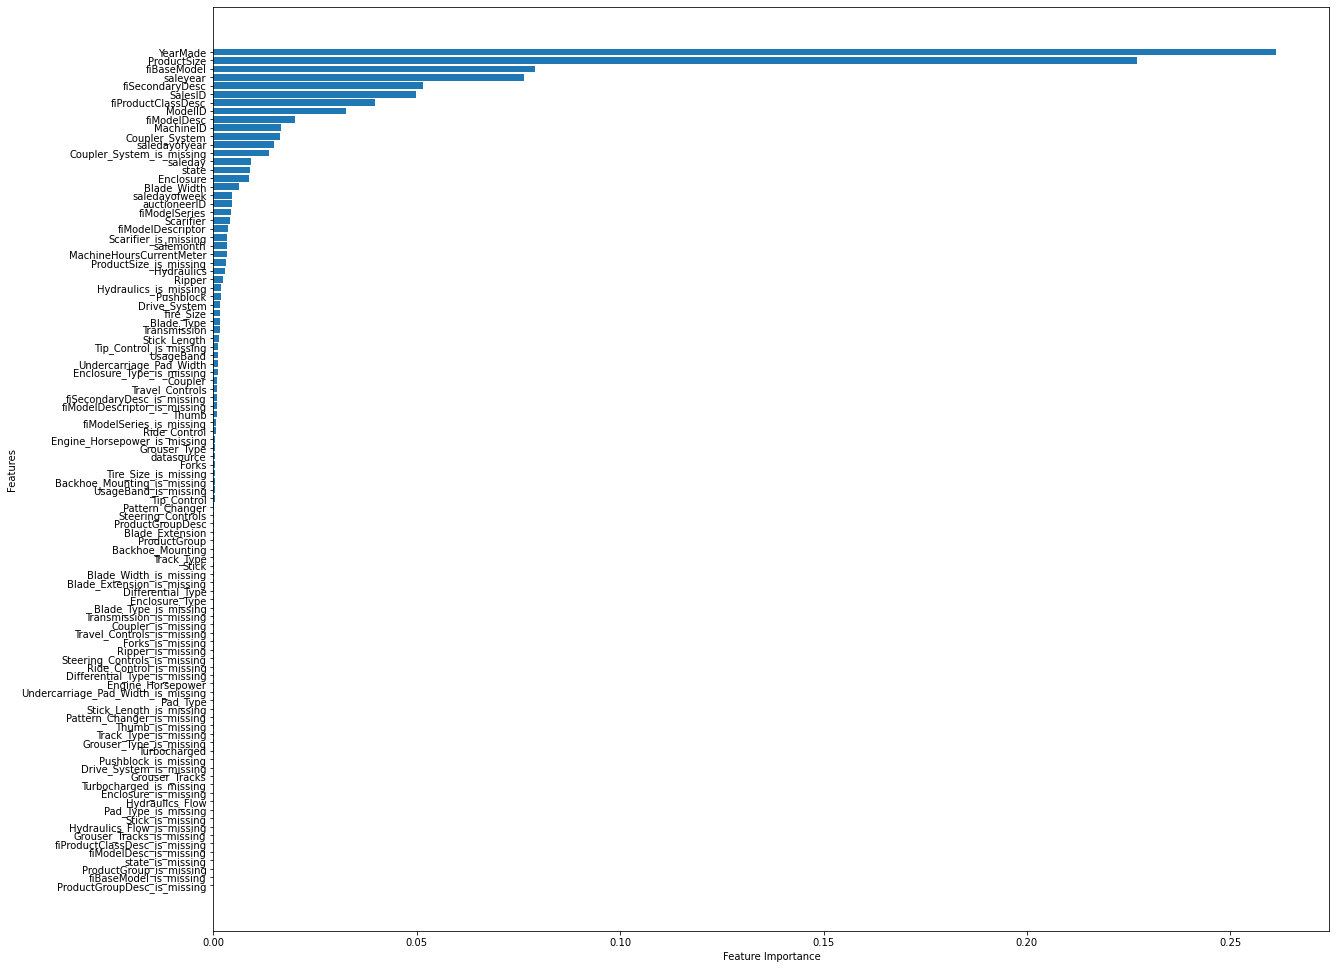

In [176]:
# Plot the df_plot for a more visual representation of the data
fig, ax = plt.subplots(figsize = (20,17))
ax.barh(df_plot.features, df_plot.feature_importance)
ax.set_ylabel("Features")
ax.set_xlabel("Feature Importance")
ax.invert_yaxis()